In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [81]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import backend as K
#from tensorflow.python.keras import backend as K
import glob
from keras.layers import Input, Lambda, Conv2D, MaxPooling2D, Flatten, Concatenate, Dense, BatchNormalization, Dropout, Reshape, LeakyReLU
from keras.optimizers import Adam
from keras.models import Model
from matplotlib import pyplot

In [96]:
all_files = glob.glob("data/autopilot_*.csv")
#all_files = glob.glob("data/autopilot_2019_03_18__13_20_22.csv")

li = []
iFile = 0
for filename in all_files:
    iFile = iFile+1
    print(iFile * '=' + (len(all_files) - iFile) * '.', "Loading", filename, end='\r')
    df = pd.read_csv(filename, header=None)
    df.drop(df.tail(1).index,inplace=True)
    li.append(df.sample(frac=1))

print("Concat all")
dataset = pd.concat(li, axis=0).sample(frac=1)
#dataset = dataset.iloc[:int(dataset.shape[0] * .2),:]
#DEV TO REDUCE DATASET
#dataset = dataset.iloc[:1000,:]

Y_data = dataset.iloc[:,-2:]
X_data = dataset.iloc[:,:-2]
print("Done")

Concat all=================================================== Loading data/autopilot_2019_03_18__12_40_09.csv
Done


In [97]:
split_offset = int(X_data.shape[0] * .05)
Y_test  = Y_data.iloc[:split_offset,:]
Y_train = Y_data.iloc[split_offset:,:]
X_test  = X_data.iloc[:split_offset,:]
X_train = X_data.iloc[split_offset:,:]
assert X_train.shape[1] == X_test.shape[1]
assert Y_train.shape[1] == Y_test.shape[1]
assert X_train.shape[0] == Y_train.shape[0]
assert X_test.shape[0] == Y_test.shape[0]
print(X_train.shape[1], "feature values")
print(Y_train.shape[1], "output values")
print(X_train.shape[0], "training lines")
print(Y_test.shape[0], "testing lines")

2271 feature values
2 output values
110137 training lines
5796 testing lines


In [107]:
first_selfcar_inputs = 3
features_by_car = 6
cells_by_row = 18
car_features = cells_by_row * cells_by_row * features_by_car
blocks_offset = first_selfcar_inputs + car_features

raw_input = Input(shape=(X_train.shape[1],), name='raw_input')

selfcar = Lambda(
    lambda x: K.slice(x, [0,0], [-1,first_selfcar_inputs]),
    output_shape=(first_selfcar_inputs,),
    name='selfcar_input'
)(raw_input)

blocks = Lambda(
    lambda x: K.slice(x, [0,blocks_offset], [-1,-1]),
    output_shape=(cells_by_row * cells_by_row,),
    name='blocks_input_slice'
)(raw_input)

blocks = Reshape(
    (cells_by_row, cells_by_row, 1,),
    input_shape=(cells_by_row, cells_by_row, 1,),
    name='blocks_input_reshape'
)(blocks)

cars = Lambda(
    lambda x: K.slice(x, [0,first_selfcar_inputs], [-1,car_features]),
    output_shape=(car_features,),
    name='cars_input_slice'
)(raw_input)

cars = Reshape(
    (cells_by_row, cells_by_row, features_by_car,),
    input_shape=(cells_by_row * cells_by_row * features_by_car,),
    name='cars_input_reshape'
)(cars)

reluActivation = LeakyReLU(name='leaky_relu')

selfcar = BatchNormalization()(selfcar)
selfcar = Dense(4, activation=reluActivation, name='dense_selfcar_1')(selfcar)
selfcar = BatchNormalization()(selfcar)
selfcar = Dense(8, activation=reluActivation, name='dense_selfcar_2')(selfcar)
selfcar = BatchNormalization()(selfcar)
selfcar = Dense(8, activation=reluActivation, name='dense_selfcar_3')(selfcar)

blocks = Conv2D(8, (4, 4), padding='same', name='conv_blocks_0')(blocks)
blocks = BatchNormalization()(blocks)
blocks = Conv2D(16, (2, 2), name='conv_blocks_1')(blocks)
blocks = BatchNormalization()(blocks)
blocks = MaxPooling2D((2, 2), name='max_blocks_1')(blocks)
blocks = Conv2D(32, (2, 2), name='conv_blocks_2')(blocks)
blocks = BatchNormalization()(blocks)
blocks = MaxPooling2D((2, 2), name='max_blocks_2')(blocks)
blocks = Conv2D(64, (1, 1), name='conv_blocks_3')(blocks)
blocks = BatchNormalization()(blocks)
blocks = MaxPooling2D((2, 2), name='max_blocks_3')(blocks)
blocks = Conv2D(128, (1, 1), name='conv_blocks_4')(blocks)
blocks = BatchNormalization()(blocks)
blocks = Flatten(name='flatten_blocks')(blocks)
blocks = Dense(32, activation=reluActivation, name='dense_blocks_1')(Concatenate()([blocks, selfcar]))
blocks = BatchNormalization()(blocks)
blocks = Dense(16, activation=reluActivation, name='dense_blocks_2')(blocks)
blocks = BatchNormalization()(blocks)
blocks = Dense(8, activation=reluActivation, name='dense_blocks_3')(blocks)
blocks = BatchNormalization()(blocks)
blocks = Dense(4, activation=reluActivation, name='dense_blocks_4')(blocks)
blocks = BatchNormalization()(blocks)
blocks = Dense(2, activation=reluActivation, name='dense_blocks_5')(blocks)

cars = Conv2D(8, (2, 2), padding='same', name='conv_cars_0')(cars)
cars = BatchNormalization()(cars)
cars = Conv2D(16, (1, 1), name='conv_cars_1')(cars)
cars = BatchNormalization()(cars)
cars = MaxPooling2D((2, 2), name='max_cars_1')(cars)
cars = Conv2D(32, (1, 1), name='conv_cars_2')(cars)
cars = BatchNormalization()(cars)
cars = MaxPooling2D((2, 2), name='max_cars_2')(cars)
cars = Conv2D(64, (1, 1), name='conv_cars_3')(cars)
cars = BatchNormalization()(cars)
cars = MaxPooling2D((2, 2), name='max_cars_3')(cars)
cars = Flatten(name='flatten_cars')(cars)
cars = Dense(8, activation=reluActivation, name='dense_cars_1')(Concatenate()([cars, selfcar]))
cars = BatchNormalization()(cars)
cars = Dense(4, activation=reluActivation, name='dense_cars_2')(cars)
cars = BatchNormalization()(cars)
cars = Dense(2, activation=reluActivation, name='dense_cars_3')(cars)

all_features = Concatenate(name='all_features')([blocks, cars, selfcar])
all_features = BatchNormalization()(all_features)
all_features = Dense(8, activation=reluActivation)(all_features)
all_features = BatchNormalization()(all_features)
all_features = Dense(4, activation=reluActivation)(all_features)
all_features = BatchNormalization()(all_features)
driving = Dense(2, activation='tanh')(all_features)

In [108]:
def acceptation(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true) < .2, axis=-1)

model = Model(inputs=raw_input, outputs=driving, name='first_try')
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=[acceptation])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
raw_input (InputLayer)          (None, 2271)         0                                            
__________________________________________________________________________________________________
blocks_input_slice (Lambda)     (None, 324)          0           raw_input[0][0]                  
__________________________________________________________________________________________________
blocks_input_reshape (Reshape)  (None, 18, 18, 1)    0           blocks_input_slice[0][0]         
__________________________________________________________________________________________________
conv_blocks_0 (Conv2D)          (None, 18, 18, 8)    136         blocks_input_reshape[0][0]       
__________________________________________________________________________________________________
batch_norm

In [99]:
history = model.fit(X_train, Y_train, epochs=15, batch_size=64, validation_data=(X_test, Y_test))

Train on 110137 samples, validate on 5796 samples
Epoch 1/15
110137/110137 [==============================] - 121s 1ms/step - loss: 0.1389 - acceptation: 0.3984 - val_loss: 0.1345 - val_acceptation: 0.3951
Epoch 2/15
110137/110137 [==============================] - 121s 1ms/step - loss: 0.1385 - acceptation: 0.3993 - val_loss: 0.1346 - val_acceptation: 0.4128
Epoch 3/15
110137/110137 [==============================] - 120s 1ms/step - loss: 0.1378 - acceptation: 0.4017 - val_loss: 0.1346 - val_acceptation: 0.4007
Epoch 4/15
110137/110137 [==============================] - 120s 1ms/step - loss: 0.1373 - acceptation: 0.4023 - val_loss: 0.1347 - val_acceptation: 0.3972
Epoch 5/15
110137/110137 [==============================] - 121s 1ms/step - loss: 0.1367 - acceptation: 0.4041 - val_loss: 0.1343 - val_acceptation: 0.4018
Epoch 6/15
110137/110137 [==============================] - 120s 1ms/step - loss: 0.1360 - acceptation: 0.4056 - val_loss: 0.1345 - val_acceptation: 0.4173
Epoch 7/15
110

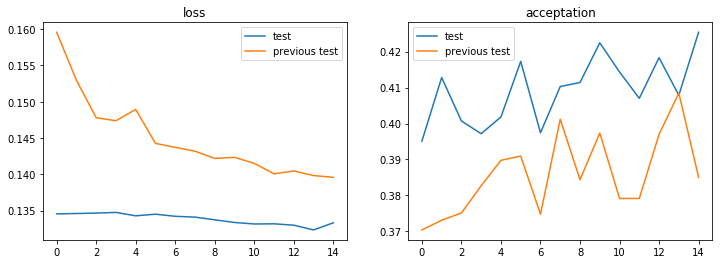

In [100]:
pyplot.figure(figsize=(12,4))

pyplot.subplot(1, 2, 1)
pyplot.title('loss')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.plot(previous_history.history['val_loss'], label='previous test')
pyplot.legend()

pyplot.subplot(1, 2, 2)
pyplot.title('acceptation')
pyplot.plot(history.history['val_acceptation'], label='test')
pyplot.plot(previous_history.history['val_acceptation'], label='previous test')
pyplot.legend()

pyplot.show()

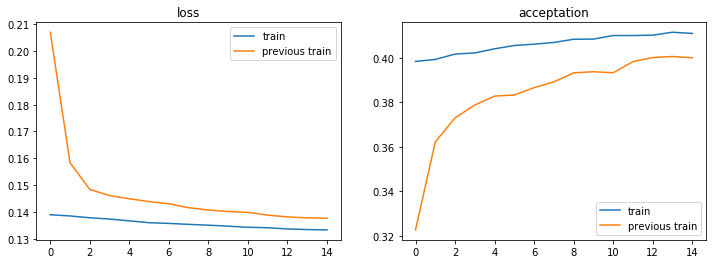

In [101]:
pyplot.figure(figsize=(12,4))

pyplot.subplot(1, 2, 1)
pyplot.title('loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(previous_history.history['loss'], label='previous train')
pyplot.legend()

pyplot.subplot(1, 2, 2)
pyplot.title('acceptation')
pyplot.plot(history.history['acceptation'], label='train')
pyplot.plot(previous_history.history['acceptation'], label='previous train')
pyplot.legend()

pyplot.show()

In [98]:
previous_model = model
previous_history = history

In [103]:
for index in range(110, 115):
    print(Y_test.values[index])
    print(model.predict(X_test.values[index:index+1,:])[0])
    print("---------")

[-0.25131832  0.74865951]
[0.01163872 0.57854486]
---------
[0.40175378 0.11442821]
[0.40719676 0.23735079]
---------
[-0.60059601  0.64144502]
[-0.38385963  0.5992314 ]
---------
[0.74539247 0.11928061]
[0.01413749 0.49745277]
---------
[0.23726925 0.25103223]
[-0.2232786   0.26819518]
---------


In [104]:
import os, time
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import tag_constants, signature_constants, signature_def_utils_impl

prediction_signature = tf.saved_model.signature_def_utils.predict_signature_def(
    {"raw": model.input},
    {"drive": model.output}
)
export_path = os.path.join(
    tf.compat.as_bytes('models/export/{}'.format(model.name)),
    tf.compat.as_bytes('9')
)
builder = saved_model_builder.SavedModelBuilder(export_path)
sess = K.get_session()
builder.add_meta_graph_and_variables(
    sess, [tag_constants.SERVING],
    signature_def_map={'raw': prediction_signature}
)
builder.save()

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/export/first_try/9/saved_model.pb


b'models/export/first_try/9/saved_model.pb'

In [111]:
#with open('%s/model.yaml'% export_path.decode("utf-8"), 'a') as the_file:
#    the_file.write(model.to_yaml())
#with open('%s/model.json'% export_path.decode("utf-8"), 'a') as the_file:
#    the_file.write(model.to_json())
model.save('%s/model.h5' % export_path.decode("utf-8"))
model.save_weights('%s/weights.h5' % export_path.decode("utf-8"))

AttributeError: 'LeakyReLU' object has no attribute '__name__'